# Brain network exploration with `neurolib`

In this example, we will run a parameter exploration of a whole-brain model that we load using the brain simulation framework `neurolib`. Please visit the [Github repo](https://github.com/neurolib-dev/neurolib) to learn more about this library or read the [gentle introduction to `neurolib`](https://caglorithm.github.io/notebooks/neurolib-intro/) to learn more about the neuroscience background of neural mass models and whole-brain simulations. 

In [1]:
# change into the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

%load_ext autoreload
%autoreload 2

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

!pip install neurolib
from neurolib.models.aln import ALNModel
from neurolib.utils.loadData import Dataset
import neurolib.utils.functions as func
ds = Dataset("hcp")

import mopet

We load a model with parameters that generate interesting dynamics.

In [3]:
model = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
model.params['duration'] = 0.2*60*1000 
model.params['mue_ext_mean'] = 1.57
model.params['mui_ext_mean'] = 1.6
# We set an appropriate level of noise
model.params['sigma_ou'] = 0.09
# And turn on adaptation with a low value of spike-triggered adaptation currents.
model.params['b'] = 5.0

INFO:root:aln: Model initialized.


Let's run it to see what kind of output it produces!

In [4]:
model.run(bold=True, chunkwise=True)

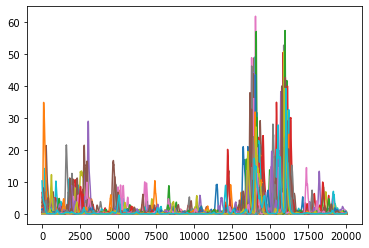

In [5]:
plt.plot(model.output.T);

We simualted the model with BOLD output, so let's compute the functional connectivity (fc) matrix:

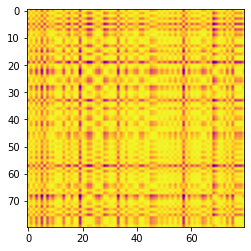

In [6]:
plt.imshow(func.fc(model.BOLD.BOLD[:, model.BOLD.t_BOLD > 5000]))

This is our multi-stage evaluation function.

In [7]:
def evaluateSimulation(params):
    model.params.update(params)
    defaultDuration = model.params['duration']
    invalid_result = {"fc" : [0]* len(ds.BOLDs)}
    
    logging.info("Running stage 1")    
    # -------- stage wise simulation --------    
    # Stage 1 : simulate for a few seconds to see if there is any activity
    # ---------------------------------------
    model.params['duration'] = 3*1000.
    model.run()
    # check if stage 1 was successful
    amplitude = np.max(model.output[:, model.t > 500]) - np.min(model.output[:, model.t > 500])
    if amplitude < 0.05:
        invalid_result = {"fc" : 0}
        return invalid_result
    
    logging.info("Running stage 2")
    # Stage 2: simulate BOLD for a few seconds to see if it moves
    # ---------------------------------------
    model.params['duration'] = 20*1000.
    model.run(bold = True, chunkwise=True)
    
    if np.std(model.BOLD.BOLD[:, 5:10]) < 0.0001:
        invalid_result = {"fc" : -1}
        return invalid_result
    
    logging.info("Running stage 3")
    # Stage 3: full and final simulation
    # ---------------------------------------
    model.params['duration'] = defaultDuration
    model.run(bold = True, chunkwise=True)
    
    # -------- evaluation here --------
    scores = []
    for i, fc in enumerate(ds.FCs):#range(len(ds.FCs)):
        fc_score = func.matrix_correlation(func.fc(model.BOLD.BOLD[:, 5:]), fc)
        scores.append(fc_score)
    
    meanScore = np.mean(scores)
    result_dict = {"fc" : meanScore}
    return result_dict

We test run the evaluation function.

In [8]:
model.params['duration'] = 20*1000.
evaluateSimulation(model.params)

INFO:root:Running stage 1
INFO:root:Running stage 2
INFO:root:Running stage 3


{'fc': 0.47791339371570196}

In [9]:
# NOTE: These values are low for testing
model.params['duration'] = 10*1000.

explore_params = {"a": np.linspace(0, 40.0, 2)
                 ,"K_gl": np.linspace(100, 400, 2)
                 ,"sigma_ou" : np.linspace(0.1, 0.5, 2)
                 }

# we need this random filename to avoid testing clashes
hdf_filename = f"exploration-{np.random.randint(99999)}.h5"
ex = mopet.Exploration(evaluateSimulation, explore_params, default_params=model.params, hdf_filename=hdf_filename)

In [10]:
ex.run()

2021-02-15 14:41:45,628	INFO resource_spec.py:212 -- Starting Ray with 2.93 GiB memory available for workers and up to 1.49 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-15 14:41:46,030	INFO services.py:1093 -- View the Ray dashboard at localhost:8265
INFO:root:Starting 8 jobs.
100%|██████████| 8/8 [00:03<00:00,  2.07it/s]
INFO:root:Runs took 3.9077529907226562 s to submit.
100%|██████████| 8/8 [00:41<00:00,  5.22s/it]
INFO:root:Runs and storage took 41.760748624801636 s to complete.


In [11]:
ex.load_results(as_dict=True)

INFO:root:exploration-32981.h5 opened for reading.
INFO:root:Gettings runs of exploration ``exploration_2021_02_15_14H_41M_45S``
100%|██████████| 8/8 [00:00<00:00, 274.65it/s]
INFO:root:Creating new results DataFrame
INFO:root:Aggregating all results ...
100%|██████████| 8/8 [00:00<00:00, 672.37it/s]
INFO:root:exploration-32981.h5 closed.


In [12]:
ex.results

{0: {'fc': 0.47714049585686386},
 1: {'fc': 0.21224795010640501},
 2: {'fc': 0.5020328111509204},
 3: {'fc': 0.20761353986442857},
 4: {'fc': 0},
 5: {'fc': 0.520090340052364},
 6: {'fc': 0},
 7: {'fc': 0.4901571834071358}}

In [13]:
ex.params

{0: {'K_gl': 100.0, 'a': 0.0, 'sigma_ou': 0.1},
 1: {'K_gl': 100.0, 'a': 0.0, 'sigma_ou': 0.5},
 2: {'K_gl': 400.0, 'a': 0.0, 'sigma_ou': 0.1},
 3: {'K_gl': 400.0, 'a': 0.0, 'sigma_ou': 0.5},
 4: {'K_gl': 100.0, 'a': 40.0, 'sigma_ou': 0.1},
 5: {'K_gl': 100.0, 'a': 40.0, 'sigma_ou': 0.5},
 6: {'K_gl': 400.0, 'a': 40.0, 'sigma_ou': 0.1},
 7: {'K_gl': 400.0, 'a': 40.0, 'sigma_ou': 0.5}}

In [14]:
ex.df

,K_gl,a,sigma_ou,fc
0,100,0,0.1,0.477140
1,100,0,0.5,0.212248
2,400,0,0.1,0.502033
3,400,0,0.5,0.207614
4,100,40,0.1,0.000000
5,100,40,0.5,0.520090
6,400,40,0.1,0.000000
7,400,40,0.5,0.490157


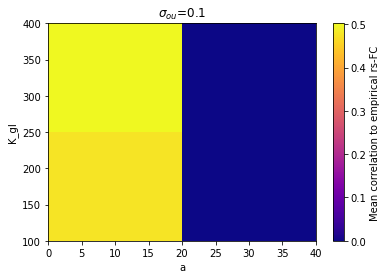

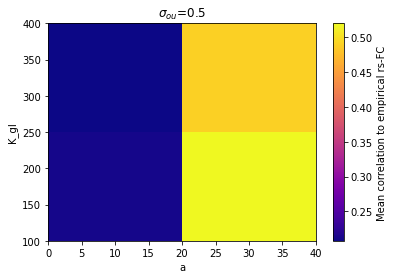

In [15]:
sigma_selectors = np.unique(ex.df.sigma_ou)
for s in sigma_selectors:
    df = ex.df[(ex.df.sigma_ou == s)]

    pivotdf = df.pivot_table(values='fc', index = 'K_gl', columns='a')
    plt.imshow(pivotdf, \
           extent = [min(df.a), max(df.a),
                     min(df.K_gl), max(df.K_gl)], origin='lower', aspect='auto')
    plt.colorbar(label='Mean correlation to empirical rs-FC')
    plt.xlabel("a")
    plt.ylabel("K_gl")
    plt.title("$\sigma_{ou}$" + "={}".format(s))
    plt.show()